# COMP0005 - GROUP COURSEWORK
# Experimental Evaluation of Search Data Structures and Algorithms

The cell below defines **AbstractSearchInterface**, an interface to support basic insert/search operations; you will need to implement this three times, to realise your three search data structures of choice among: (1) *2-3 Tree*, (2) *AVL Tree*, (3) *LLRB BST*; (4) *B-Tree*; and (5) *Scapegoat Tree*. <br><br>**Do NOT modify the next cell** - use the dedicated cells further below for your implementation instead. <br>

In [1]:
# DO NOT MODIFY THIS CELL

from abc import ABC, abstractmethod  

class AbstractSearchInterface(ABC):
    '''
    Abstract class to support search/insert operations (plus underlying data structure)
    
    '''
        
    @abstractmethod
    def insertElement(self, element):     
        '''
        Insert an element in a search tree
            Parameters:
                    element: string to be inserted in the search tree (string)

            Returns:
                    "True" after successful insertion, "False" if element is already present (bool)
        '''
        
        pass 
    

    @abstractmethod
    def searchElement(self, element):
        '''
        Search for an element in a search tree
            Parameters:
                    element: string to be searched in the search tree (string)

            Returns:
                    "True" if element is found, "False" otherwise (bool)
        '''

        pass

Use the cell below to define any auxiliary data structure and python function you may need. Leave the implementation of the main API to the next code cells instead.

In [2]:
# ADD AUXILIARY DATA STRUCTURE DEFINITIONS AND HELPER CODE HERE

import random
import string
import timeit
import matplotlib.pyplot as plt

#####################
# AVL Tree Helpers
#####################

class AVLNode:
    def __init__(self, key):
        self.key = key
        self.left = None
        self.right = None
        self.height = 1

def avl_getHeight(node):
    return node.height if node else 0

def avl_getBalance(node):
    return avl_getHeight(node.left) - avl_getHeight(node.right) if node else 0

def avl_rightRotate(z):
    y = z.left
    T3 = y.right
    y.right = z
    z.left = T3
    z.height = 1 + max(avl_getHeight(z.left), avl_getHeight(z.right))
    y.height = 1 + max(avl_getHeight(y.left), avl_getHeight(y.right))
    return y

def avl_leftRotate(z):
    y = z.right
    T2 = y.left
    y.left = z
    z.right = T2
    z.height = 1 + max(avl_getHeight(z.left), avl_getHeight(z.right))
    y.height = 1 + max(avl_getHeight(y.left), avl_getHeight(y.right))
    return y

def avl_insert(root, key):
    """Recursively insert key into the AVL tree rooted at 'root'.  
       Returns a tuple: (new_root, inserted) where inserted is True if key was added."""
    if not root:
        return AVLNode(key), True
    if key == root.key:
        return root, False  # key already exists
    elif key < root.key:
        root.left, inserted = avl_insert(root.left, key)
    else:
        root.right, inserted = avl_insert(root.right, key)
    
    root.height = 1 + max(avl_getHeight(root.left), avl_getHeight(root.right))
    balance = avl_getBalance(root)
    
    # Left Left Case
    if balance > 1 and key < root.left.key:
        return avl_rightRotate(root), inserted
    # Right Right Case
    if balance < -1 and key > root.right.key:
        return avl_leftRotate(root), inserted
    # Left Right Case
    if balance > 1 and key > root.left.key:
        root.left = avl_leftRotate(root.left)
        return avl_rightRotate(root), inserted
    # Right Left Case
    if balance < -1 and key < root.right.key:
        root.right = avl_rightRotate(root.right)
        return avl_leftRotate(root), inserted
    
    return root, inserted

def avl_search(root, key):
    if not root:
        return False
    if key == root.key:
        return True
    elif key < root.key:
        return avl_search(root.left, key)
    else:
        return avl_search(root.right, key)

#########################
# LLRB BST Helpers
#########################

# Colors: True represents RED, False represents BLACK.
RED = True
BLACK = False

class LLRBNode:
    def __init__(self, key, color=RED):
        self.key = key
        self.color = color  
        self.left = None
        self.right = None

def llrb_isRed(node):
    return node is not None and node.color == RED

def llrb_rotateLeft(h):
    x = h.right
    h.right = x.left
    x.left = h
    x.color = h.color
    h.color = RED
    return x

def llrb_rotateRight(h):
    x = h.left
    h.left = x.right
    x.right = h
    x.color = h.color
    h.color = RED
    return x

def llrb_flipColors(h):
    h.color = RED if h.color == BLACK else BLACK
    if h.left:
        h.left.color = BLACK if h.left.color == RED else RED
    if h.right:
        h.right.color = BLACK if h.right.color == RED else RED

def llrb_insert(root, key):
    """Insert key into the LLRB tree rooted at 'root'.
       Returns a tuple (new_root, inserted)."""
    if not root:
        return LLRBNode(key, RED), True
    if key == root.key:
        return root, False
    elif key < root.key:
        root.left, inserted = llrb_insert(root.left, key)
    else:
        root.right, inserted = llrb_insert(root.right, key)
    
    # Fix right-leaning red links and balance
    if llrb_isRed(root.right) and not llrb_isRed(root.left):
        root = llrb_rotateLeft(root)
    if llrb_isRed(root.left) and llrb_isRed(root.left.left):
        root = llrb_rotateRight(root)
    if llrb_isRed(root.left) and llrb_isRed(root.right):
        llrb_flipColors(root)
    
    return root, inserted

def llrb_search(root, key):
    current = root
    while current:
        if key == current.key:
            return True
        elif key < current.key:
            current = current.left
        else:
            current = current.right
    return False

#####################
# B-Tree Helpers (Minimum Degree t = 2)
#####################

class BTreeNode:
    def __init__(self, t, leaf=False):
        self.t = t              # Minimum degree
        self.keys = []          # List of keys
        self.children = []      # List of child pointers
        self.leaf = leaf

def btree_search(node, key):
    i = 0
    while i < len(node.keys) and key > node.keys[i]:
        i += 1
    if i < len(node.keys) and key == node.keys[i]:
        return True
    if node.leaf:
        return False
    return btree_search(node.children[i], key)

def btree_splitChild(parent, i):
    t = parent.t
    node = parent.children[i]
    newNode = BTreeNode(t, leaf=node.leaf)
    # newNode takes last t-1 keys of node
    newNode.keys = node.keys[t:]
    node.keys = node.keys[:t-1]
    if not node.leaf:
        newNode.children = node.children[t:]
        node.children = node.children[:t]
    parent.children.insert(i+1, newNode)
    # Move the middle key up to the parent
    parent.keys.insert(i, node.keys.pop())

def btree_insertNonFull(node, key):
    i = len(node.keys) - 1
    if node.leaf:
        node.keys.append(None)  # placeholder
        while i >= 0 and key < node.keys[i]:
            node.keys[i+1] = node.keys[i]
            i -= 1
        node.keys[i+1] = key
    else:
        while i >= 0 and key < node.keys[i]:
            i -= 1
        i += 1
        if len(node.children[i].keys) == (2 * node.t - 1):
            btree_splitChild(node, i)
            if i < len(node.keys) and key > node.keys[i]:
                i += 1

        btree_insertNonFull(node.children[i], key)

def btree_insert(tree, key):
    """Insert key into the B-Tree 'tree'. 'tree' is assumed to have attributes 'root' and 't'."""
    # First, check if the key is already in the tree
    if btree_search(tree.root, key):
        return False
    root = tree.root
    if len(root.keys) == (2 * tree.t - 1):
        newRoot = BTreeNode(tree.t, leaf=False)
        newRoot.children.append(root)
        newRoot.t = tree.t  # ensure minimum degree is set
        btree_splitChild(newRoot, 0)
        tree.root = newRoot
        btree_insertNonFull(newRoot, key)
    else:
        btree_insertNonFull(root, key)
    return True

def btree_searchTree(tree, key):
    return btree_search(tree.root, key)


Use the cell below to implement the requested API by means of **2-3 Tree** (if among your chosen data structure).

In [3]:
class TwoThreeTree(AbstractSearchInterface):
        
    def insertElement(self, element):
        inserted = False
        # ADD YOUR CODE HERE
      
        
        return inserted
    
    

    def searchElement(self, element):     
        found = False
        # ADD YOUR CODE HERE

        
        return found    

Use the cell below to implement the requested API by means of **AVL Tree** (if among your chosen data structure).

In [4]:
# class AVLTree(AbstractSearchInterface):
        
#     def insertElement(self, element):
#         inserted = False
#         # ADD YOUR CODE HERE
      
        
#         return inserted
    
    

#     def searchElement(self, element):     
#         found = False
#         # ADD YOUR CODE HERE

        
#         return found  
class AVLTree(AbstractSearchInterface):
        
    def __init__(self):
        self.root = None

    def insertElement(self, element):
        self.root, inserted = avl_insert(self.root, element)
        return inserted
    
    def searchElement(self, element):
        return avl_search(self.root, element)


Use the cell below to implement the requested API by means of **LLRB BST** (if among your chosen data structure).

In [5]:
# class LLRBBST(AbstractSearchInterface):
        
#     def insertElement(self, element):
#         inserted = False
#         # ADD YOUR CODE HERE
      
        
#         return inserted
    
    

#     def searchElement(self, element):     
#         found = False
#         # ADD YOUR CODE HERE

        
#         return found  
class LLRBBST(AbstractSearchInterface):
        
    def __init__(self):
        self.root = None

    def insertElement(self, element):
        self.root, inserted = llrb_insert(self.root, element)
        # Ensure the root is always black
        if self.root:
            self.root.color = BLACK
        return inserted
    
    def searchElement(self, element):
        return llrb_search(self.root, element)


Use the cell below to implement the requested API by means of **B-Tree** (if among your chosen data structure).

In [6]:
# class BTree(AbstractSearchInterface):
        
#     def insertElement(self, element):
#         inserted = False
#         # ADD YOUR CODE HERE
      
        
#         return inserted
    
    

#     def searchElement(self, element):     
#         found = False
#         # ADD YOUR CODE HERE

        
#         return found
class BTree(AbstractSearchInterface):
        
    def __init__(self, t=2):
        self.t = t
        # Create an initial empty root node (a leaf)
        self.root = BTreeNode(t, leaf=True)

    def insertElement(self, element):
        inserted = btree_insert(self, element)
        return inserted
    
    def searchElement(self, element):
        return btree_searchTree(self, element)


Use the cell below to implement the requested API by means of **Scapegoat Tree** (if among your chosen data structure).

In [7]:
class ScapegoatTree(AbstractSearchInterface):
        
    def insertElement(self, element):
        inserted = False
        # ADD YOUR CODE HERE
      
        
        return inserted
    
    

    def searchElement(self, element):     
        found = False
        # ADD YOUR CODE HERE

        
        return found 

Use the cell below to implement the **synthetic data generator** needed by your experimental framework (be mindful of code readability and reusability).

In [8]:
# import string
# import random

# class TestDataGenerator():
#     '''
#     A class to represent a synthetic data generator.

#     ...

#     Attributes
#     ----------
    
#     [to be defined as part of the coursework]

#     Methods
#     -------
    
#     [to be defined as part of the coursework]

#     '''
    
#     #ADD YOUR CODE HERE
    
#     # def __init__():
#     #     pass
    
    
class TestDataGenerator:
    '''
    A class to represent a synthetic data generator.
    '''
    def __init__(self, size, length=10):
        self.size = size
        self.length = length
    
    def generate_data(self):
        return [''.join(random.choices(string.ascii_letters, k=self.length)) 
                for _ in range(self.size)]


Use the cell below to implement the requested **experimental framework** (be mindful of code readability and reusability).

In [9]:
# import timeit
# import matplotlib

# class ExperimentalFramework():
#     '''
#     A class to represent an experimental framework.

#     ...

#     Attributes
#     ----------
    
#     [to be defined as part of the coursework]

#     Methods
#     -------
    
#     [to be defined as part of the coursework]

#     '''
            
#     #ADD YOUR CODE HERE
    
#     def __init__():
#         pass
    
class ExperimentalFramework:
    '''
    A class to represent an experimental framework.
    '''
    def __init__(self, data_structures, dataset_sizes):
        # data_structures is a dictionary mapping names to instances
        self.data_structures = data_structures
        self.dataset_sizes = dataset_sizes
        # Results stored as: {name: [(dataset_size, avg_insert_time, avg_search_time), ...]}
        self.results = {}
    
    def run_experiment(self):
        for size in self.dataset_sizes:
            data_gen = TestDataGenerator(size)
            dataset = data_gen.generate_data()
            for name, ds in self.data_structures.items():
                # Create a fresh instance for each run for fairness
                if name == 'AVL Tree':
                    ds = AVLTree()
                elif name == 'LLRB BST':
                    ds = LLRBBST()
                elif name == 'B-Tree':
                    ds = BTree(t=2)
                else:
                    continue
                
                insert_times = []
                search_times = []
                
                # Measure insertion times (excluding data generation overhead)
                for item in dataset:
                    start = timeit.default_timer()
                    ds.insertElement(item)
                    insert_times.append(timeit.default_timer() - start)
                
                # Measure search times
                for item in dataset:
                    start = timeit.default_timer()
                    ds.searchElement(item)
                    search_times.append(timeit.default_timer() - start)
                
                avg_insert = sum(insert_times) / len(insert_times) if insert_times else 0
                avg_search = sum(search_times) / len(search_times) if search_times else 0
                self.results.setdefault(name, []).append((size, avg_insert, avg_search))
    
    def plot_results(self):
    # Plot insertion times in a separate figure
        plt.figure(figsize=(10, 5))
        for name, data in self.results.items():
            sizes, insert_times, _ = zip(*data)
            plt.plot(sizes, insert_times, marker='o', label=name)
        plt.xlabel('Dataset Size')
        plt.ylabel('Average Insertion Time (s) per operation')
        plt.title('Insertion Performance of Search Data Structures')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot search times in a separate figure
        plt.figure(figsize=(10, 5))
        for name, data in self.results.items():
            sizes, _, search_times = zip(*data)
            plt.plot(sizes, search_times, marker='o', label=name)
        plt.xlabel('Dataset Size')
        plt.ylabel('Average Search Time (s) per operation')
        plt.title('Search Performance of Search Data Structures')
        plt.legend()
        plt.grid(True)
        plt.show()



Use the cell below to illustrate the python code you used to **fully evaluate** your three chosen search data structures and algortihms. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each data structure using such data, collect information about their execution time, plot results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

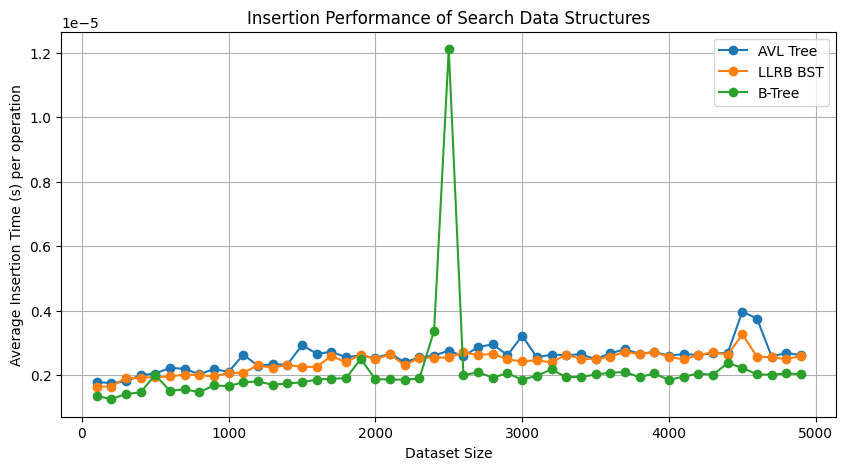

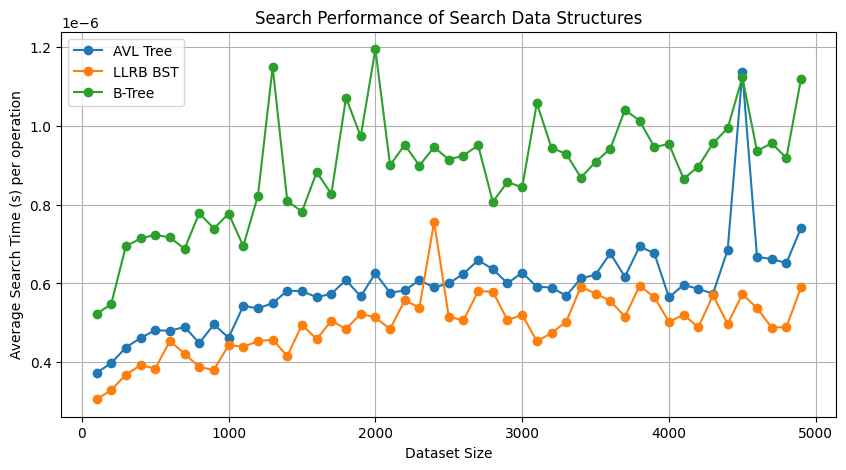

In [10]:
# ADD YOUR TEST CODE HERE 


# Example test code: choose three data structures and run experiments.
if __name__ == '__main__':
    data_structures = {
        'AVL Tree': AVLTree(),
        'LLRB BST': LLRBBST(),
        'B-Tree': BTree(t=2)
    }
    # Define various dataset sizes to stress-test the structures.
    dataset_sizes = []

    for i in range(100, 5000, 100):
        dataset_sizes.append(i)
    
    experiment = ExperimentalFramework(data_structures, dataset_sizes)
    experiment.run_experiment()
    experiment.plot_results()

